Weights and activations are stored in 16-bit floating point. Since each weight is still stored as a floating-point value, the reduction in size is moderate. The Float16 format allows for more precision and a larger range of values than integer quantization.

In [1]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import tensorflow.keras.backend as K


# Define the custom LSTM layer
class CustomLSTM(LSTM):
    def __init__(self, *args, **kwargs):
        kwargs.pop('time_major', None)
        super(CustomLSTM, self).__init__(*args, **kwargs)

# Define a custom MSE function
def custom_mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)


# Load the model
trained_model = tf.keras.models.load_model(
    r"C:\Users\pranali\Desktop\Throughput_prediction\4G-Models\Models\multivariate_medium.hdf5",
    custom_objects={'LSTM': CustomLSTM, 'mse': custom_mse}
)

# Check the model type
print(type(trained_model))

# Convert the model to a TensorFlow Lite model with Float16 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(trained_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Enable Float16 quantization
converter.target_spec.supported_types = [tf.float16]

# Enable Select TF ops to support operations not natively supported by TFLite
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, 
                                       tf.lite.OpsSet.SELECT_TF_OPS]

# Disable lowering of tensor list operations
converter._experimental_lower_tensor_list_ops = False

# Enable resource variable support
converter.experimental_enable_resource_variables = True

# Convert the model
tflite_float16_model = converter.convert()

# Save the Float16 quantized model
#with open(r"C:\Users\pranali\Downloads\float16_quantized_model_med_4g.tflite", "wb") as f:
    #f.write(tflite_float16_model)


C:\Users\pranali\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\pranali\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


<class 'keras.src.models.sequential.Sequential'>
INFO:tensorflow:Assets written to: C:\Users\pranali\AppData\Local\Temp\tmpfkyc1pv3\assets


INFO:tensorflow:Assets written to: C:\Users\pranali\AppData\Local\Temp\tmpfkyc1pv3\assets


Saved artifact at 'C:\Users\pranali\AppData\Local\Temp\tmpfkyc1pv3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 10, 10), dtype=tf.float32, name='lstm_input')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2405287645584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2405287651536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2405287652496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2405287650192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2405287654416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2405287654608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2405287650768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2405287656336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2405287656528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2405292163344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2407190999

In [3]:
# Save the TFLite model
with open('4G_med_quantized_f16.tflite', 'wb') as f:
    f.write(tflite_float16_model)

In [5]:
import numpy as np
X_test = np.load(r"C:\Users\pranali\Desktop\Throughput_prediction\test_train_vis\Testing\multivariate_medium_test_x.npy")
y_test = np.load(r"C:\Users\pranali\Desktop\Throughput_prediction\test_train_vis\Testing\multivariate_medium_test_y.npy")


In [7]:
import tensorflow as tf
import numpy as np

# Load the quantized TFLite model
interpreter = tf.lite.Interpreter(model_path='4G_med_quantized_f16.tflite')
interpreter.allocate_tensors()

# Get details of input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [9]:
# Initialize list to store predictions
import time

predictions = []

# Iterate over each sample in X_test
start_time = time.time()
for i in range(X_test.shape[0]):
    # Prepare the input data
    input_data = np.expand_dims(X_test[i], axis=0).astype(np.float32)
    
    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)
    
   
    # Run inference
    interpreter.invoke()
    
    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
end_time = time.time()
inference_time = (end_time - start_time)
print(f"Inference Time for quantized : {inference_time:.6f} seconds")

avg_inference_time = (end_time - start_time)/len(X_test)
print(f"Avg Inference Time for quantized : {avg_inference_time:.6f} seconds")



Inference Time for quantized : 22.167215 seconds
Avg Inference Time for quantized : 0.002774 seconds


In [15]:
import os


# Get the size of the saved quantized TFLite model
model_size = os.path.getsize('4G_med_quantized_f16.tflite')
print(f"Float16 TFLite model size: {model_size / 1024:.2f} KB")  # Convert to KB



Float16 TFLite model size: 909.37 KB


Mean Signed Error: -2736.2385
Median Signed Error: -2449.9324
Standard Deviation of Errors: 1670.8689


Text(0, 0.5, 'Signed Error')

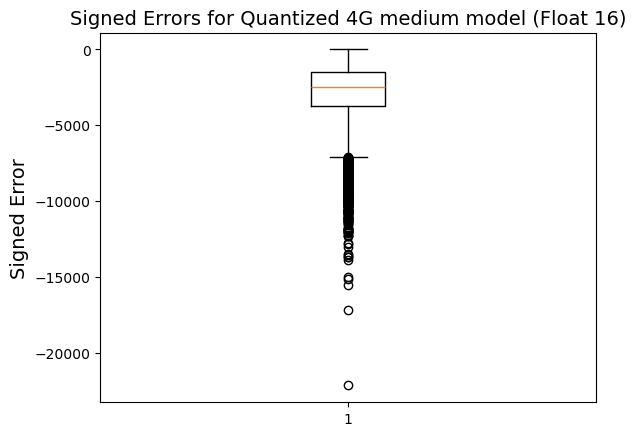

In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Run inference on the quantized model
predictions = []
for i in range(X_test.shape[0]):
    input_data = np.expand_dims(X_test[i], axis=0).astype(np.float32)  # Adjust dtype if needed
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output_data)

predictions = np.squeeze(np.array(predictions))  # Adjust shape if necessary

# Reshape y_test to match the shape of predictions
y_test_squeezed = np.squeeze(y_test)  # From (3995, 5, 1) to (3995, 5)

# Calculate signed errors
signed_errors = predictions - y_test_squeezed

# Flatten signed_errors to combine all errors into a single array
signed_errors_flattened = signed_errors.flatten()

# Error statistics
mean_error = np.mean(signed_errors)
median_error = np.median(signed_errors)
std_error = np.std(signed_errors)

print(f"Mean Signed Error: {mean_error:.4f}")
print(f"Median Signed Error: {median_error:.4f}")
print(f"Standard Deviation of Errors: {std_error:.4f}")

import matplotlib.pyplot as plt
plt.boxplot(signed_errors_flattened)
plt.title('Signed Errors for Quantized 4G medium model (Float 16)',fontsize=14)
plt.ylabel('Signed Error',fontsize=14)


In [19]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


# Calculate MAE
mae = mean_absolute_error(y_test_squeezed, predictions)
# Calculate Mean Squared Error (MSE) as the test loss
mse = mean_squared_error(y_test_squeezed, predictions)
test_loss = mse  # Assuming MSE is the loss functiona

#print(f"Mean Squared Error (MSE) of the Quantized Model: {mse:.6f}")
print(f"Test Loss (MSE) of the Quantized Model: {test_loss:.6f}")
print(f"Mean Absolute Error (MAE) of the Quantized Model: {mae:.6f}")

Test Loss (MSE) of the Quantized Model: 10278804.314682
Mean Absolute Error (MAE) of the Quantized Model: 2736.238548
